In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")

🌫🛸


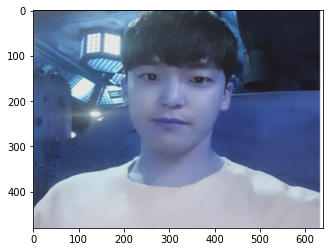

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

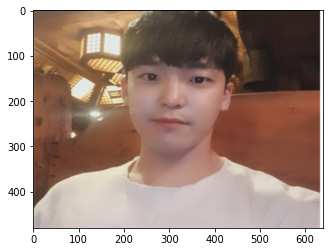

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸
🌫🛸


rectangles[[(191, 93) (414, 316)]]


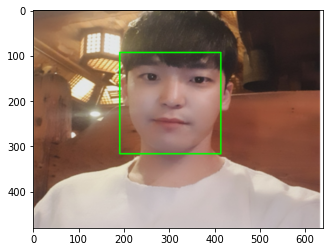

In [5]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [7]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


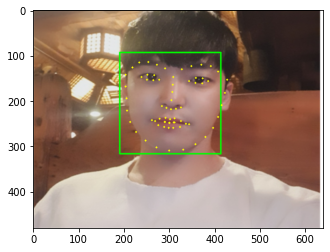

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(305, 198)
(x,y) : (305,86)
(w,h) : (224,224)


In [10]:
# 이미지에 적용시킬 스티커 좌표 확인하기

# 이미지에 적용시킬 스티커의 좌표를 찾는 함수
def sticker_position(dlib_rects, list_landmarks):    # dlib_rects = bounding box 좌표, list_landmarks = 이목구비 위치 
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks): 
        # x = landmark[30][0]    # 왕관 스티커를 붙힐 x좌표
        # y = landmark[30][1] - dlib_rect.width()//2    # 왕관 스티커를 붙힐 y좌표

        x = landmark[30][0]    # 고양이 스티커의 중심 x좌표
        y = landmark[30][1]    # 고양이 스티커의 중심 y좌표

        # w = dlib_rect.width()    # bounding box의 너비
        # h = dlib_rect.height()    # bouding box의 높이
        
        w = (landmark[30][0] - landmark[2][0]) * 2    # 고양이 스티커의 너비
        h = (landmark[48][1] - landmark[30][1]) * 2    # 고양이 스티커의 높이
    
    return x, y, w, h

x, y, w, h = sticker_position(dlib_rects, list_landmarks)    # 이미지에 적용시킬 스티커의 좌표를 찾는 함수 불러오기
print ('Image center (x,y) : (%d,%d)'%(x,y))
print ('Image size (w,h) : (%d,%d)'%(w,h))

Image center (x,y) : (305,198)
Image size (w,h) : (198,88)


top-left (x,y) : (206,154)


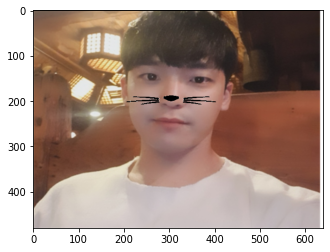

In [13]:
# 고양이 스티커 이미지를 읽어서 적용하기

# 사진 속 얼굴에 고양이 수염을 붙히는 함수
def attach_sticker(x, y, w, h, img_bgr, sticker):    # x, y, w, h = 고양이 수염 스티커의 위치와 크기, img_bgr = 고양이 수염을 붙힐 이미지, sticker = 고양이 수염 스티커의 파일의 이름 
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'    # 고양이 수염 스티커가 저장된 위치
    img_sticker = cv2.imread(sticker_path)    # openCV로 고양이 스티커 이미지 읽기
    img_sticker = cv2.resize(img_sticker, (w,h))    # 고양이 스티커 이미지 resize 하기

    # 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표 입니다.
    refined_x = x - w // 2    # left
    refined_y = y - h // 2    # top
    print ('top-left (x,y) : (%d,%d)'%(refined_x, refined_y))
    
    # 스티커 이미지의 y축이 음수인 경우 (스티커 이미지가 위쪽을 벗어난 경우)
    if (refined_y < 0):
        img_sticker = img_sticker[-refined_y:]    # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
        refined_y = 0    # top 의 y 좌표값을 원본 이미지의 경계 값으로 수정하기
       
    # 스티커 이미지의 y축이 원본 이미지의 최대 y축보다 큰 경우 (스티커 이미지가 아래쪽을 벗어난 경우)
    if ((refined_y + h) > img_bgr.shape[0]):
        img_sticker = img_sticker[:img_bgr.shape[0]-refined_y]    # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
   
    # 스티커 이미지의 x축이 음수인 경우 (스티커 이미지가 왼쪽을 벗어난 경우)
    if (refined_x < 0): 
        img_sticker = img_sticker[:, -refined_x:, :]    # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
        refined_x = 0    # left 의 x 좌표값을 원본 이미지의 경계 값으로 수정하기
    
    # 스티커 이미지의 x축이 원본 이미지의 최대 x축보다 큰 경우 (스티커 이미지가 오른쪽을 벗어난 경우)
    if ((refined_x + w) > img_bgr.shape[1]):
        img_sticker = img_sticker[:, :img_bgr.shape[1]-refined_x, :]     # 원본 이미지의 범위를 벗어난 스티커 부분을 제거하기
    
    # 원본 이미지에 스티커 적용하기
    sticker_area = img_bgr[refined_y:refined_y+h, refined_x:refined_x+w]    # 원본 이미지에 스티커를 적용시킬 부분
    img_bgr[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    # 스티커 이미지색이 255인 부분(하얀색)은 원본 이미지 색(sticker_area)을 칠하고,
    # 스티커 이미지색이 255가 아닌 부분(하얀색이외의 모든색)은 스티커 이미지색(img_sticker)을 칠한다.
    # (255,255,255) == 하얀색

attach_sticker(x, y, w, h, img_bgr, "cat-whiskers.png")    # 사진 속 얼굴에 고양이 수염을 붙히는 함수 불러오기
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))    # maplotlib 로 출력하기 위해 이미지 채널을 RGB 순으로 바꾸고, matplotlib로 이미지 출력하기
plt.show()    # 화면에 이미지 출력하기